# Compare MgSiO3 Models dK09 and S11
* compare resulting ambient properties to experiment-based models of Ghiorso and Lange

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import pickle

from collections import OrderedDict

import xmeos
from xmeos import models
from xmeos import datamod
from xmeos import modfit
CONSTS = models.CONSTS
import copy

In [2]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)
    
datasets = analysis['datasets']
param_tex_str = analysis['param_tex_str']
eos_electronic = analysis['eos_electronic']



In [3]:
data_dK09 = datasets['deKoker2009']
data_S11 = datasets['Spera2011']

eos_mod_dK09 = analysis['datamodel_dK09']['eos_mod']
eos_mod_S11 = analysis['datamodel']['eos_mod']
# View data tables
# tbl = data['table']
# tbl

In [42]:
Texp = 1773


# Properties of MgSiO3 melt
mass_avg = (24.31+28.09+3*16.0)/5.0 # g/(mol atom)
natom=5


rho_conv = 2.35023*14.1735882
ang_cc_mol = CONSTS['ang3percc']/natom/CONSTS['Nmol'] # (ang^3/atom) / (cc/mol)

def exp_properties_Ghiorso(T, Vconv=ang_cc_mol):
    """
    Ghiorso and Kress 2004
    """
    nmol = 2
    dVdT_SiO2 = 1.007e-3
    dVdT_MgO = 2.887e-3
    dVdT = 0.5*dVdT_SiO2 + 0.5*dVdT_MgO
    
    VT0_SiO2 = 26.71
    VT0_MgO = 12.015
    
    VT0 = 0.5*VT0_SiO2 + 0.5*VT0_MgO
    alpha = dVdT/VT0
    
    VT = VT0*np.exp(alpha*(T-1673))
    print(VT)

    c_MgO = 3349.96
    c_SiO2 = 2321.75
    dcdT_MgO = 275.64e-3
    dcdT_SiO2 = 399.34e-3
    
    c = 0.5*(c_MgO + dcdT_MgO*(T-1673)) + 0.5*(c_SiO2 + dcdT_SiO2*(T-1673))
    
    rho = 1e3*mass_avg/(VT*nmol/5)
    betaS = 1e9/rho/c**2
    KS = 1/betaS
    
    
    #betaT_MgO = 0.5*VT_MgO/VT*0.615e-2
    #betaT_SiO2 = 0.5*VT_SiO2/VT*7.15e-2
    #betaT = betaT_MgO + betaT_SiO2
    #K = 1/betaT
    
    props = {}
    props['P'] = 0
    props['T'] = T
    props['V'] = VT*nmol*Vconv
    props['alpha'] = alpha
    props['c'] = c
    props['rho'] = rho
    props['betaS'] = betaS
    props['KS'] = KS
    return props

def exp_properties_Lange(T, Vconv=ang_cc_mol):
    """
    Lange 1997 and Ai and Lange 2004
    """
    nmol = 2

    # V0T = +12.02
    dVdT = (0.5*0+0.5*3.27)*1e-3
    
    VT_SiO2 = 26.86
    VT_MgO = 12.02 + 3.27e-3*(T-1773)
    
    VT = 0.5*VT_SiO2 + 0.5*VT_MgO
    
    alpha = dVdT/VT
    # print(VT)
    
    betaT_MgO = 0.5*VT_MgO/VT*0.615e-2
    betaT_SiO2 = 0.5*VT_SiO2/VT*7.15e-2
    betaT = betaT_MgO + betaT_SiO2
    # print(1/betaT)
    # dVdP = (0.5*-1.922 + 0.5*-.073)
    # K = -VT/dVdP
    K = 1/betaT
 
    
    props = {}
    props['P'] = 0
    props['T'] = T
    props['V'] = nmol*VT*Vconv
    props['dVdT'] = dVdT
    props['alpha'] = alpha
    props['betaT'] = betaT
    props['KT'] = K
    return props
    
    pass
    


props_Ghiorso = exp_properties_Ghiorso(Texp)
props_Lange = exp_properties_Lange(Texp)

display(props_Lange)
display(props_Ghiorso)


19.558182194239127


{'KT': 19.49445776777428,
 'P': 0,
 'T': 1773,
 'V': 12.912350628504845,
 'alpha': 8.410493827160495e-05,
 'betaT': 0.05129663065843621,
 'dVdT': 0.001635}

{'KS': 21.13582321499818,
 'P': 0,
 'T': 1773,
 'V': 12.990849081697318,
 'alpha': 0.0001005551969012266,
 'betaS': 0.04731303767200279,
 'c': 2869.6040000000003,
 'rho': 2566.7007036464997}

In [38]:
data_1bar = pd.DataFrame(columns=['prop','val','err'])

data_1bar = data_1bar.append({'prop':'V','val':props_Lange['V'],'err':0}, ignore_index=True)
data_1bar = data_1bar.append({'prop':'K_T','val':props_Lange['KT'],'err':0}, ignore_index=True)
data_1bar = data_1bar.append({'prop':'C_V','val':4.2,'err':.2}, ignore_index=True)
data_1bar = data_1bar.append({'prop':'gamma','val':0.37,'err':.14}, ignore_index=True)

data_1bar

,prop,val,err
0,V,12.803751,0
1,K_T,19.350011,0
2,C_V,4.200000,0.2
3,gamma,0.370000,0


In [25]:
pd.concat?

In [4]:
props_Lange = analysis['props_Lange']
props_Lange

{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

In [41]:
eos_mod = eos_mod_dK09
# eos_mod = eos_mod_S11
Tref = 1673
    
    
Vref = eos_mod.volume(0, Tref)
Kref = eos_mod.bulk_mod(Vref, Tref)
alpharef = eos_mod.thermal_exp(Vref, Tref)*1e5
CVref = eos_mod.heat_capacity(Vref, Tref)
gamma_ref = eos_mod.gamma(Vref, Tref)

print('Vref', Vref)
print('Kref', Kref)
print('alpharef', alpharef)
print('CVref', CVref/CONSTS['kboltz'])
print('gammaref', gamma_ref)

Vref 12.458559147509266
Kref [21.36102989]
alpharef [10.68227748]
CVref [4.83182841]
gammaref [0.42614675]


In [3]:
def calc_thermal_data_derivs(data, remove_elec=False, eos_electronic=eos_electronic):
    tbl = data['table']
    dEdT = []
    dPdT = []
    Tavg = []
    Vavg = []

    # plt.figure()
    for Vlbl in np.round(data['V_labels'],2):
        mask = tbl['V_label']==Vlbl
        
        iE = tbl['E'][mask]
        iT = tbl['T'][mask]
        iP = tbl['P'][mask]
        iV = np.round(tbl['V'][mask],decimals=2)
        
        if remove_elec:
            iE -= eos_electronic.energy(iV, iT)
            iP -= eos_electronic.press(iV, iT)
    
        idEdT = np.diff(iE)/np.diff(iT)
        idPdT = np.diff(iP)/np.diff(iT)
    
        dEdT.extend(list(idEdT))
        dPdT.extend(list(idPdT))
    
        Tavg.extend(list(0.5*(np.array(iT[:-1]) + np.array(iT[1:]))))
        Vavg.extend(list(iV[:-1]))
    
        # plt.plot(tbl['T'][mask], tbl['E'][mask], 'ko-')

    Vavg = np.array(Vavg)
    Tavg = np.array(Tavg)
    dEdT = np.array(dEdT)
    dPdT = np.array(dPdT)
    
    thermal_deriv = OrderedDict()
    thermal_deriv['Vavg'] = Vavg
    thermal_deriv['Tavg'] = Tavg
    thermal_deriv['dEdT'] = dEdT
    thermal_deriv['dPdT'] = dPdT
    
    return thermal_deriv

def calc_heat_capacity(data, remove_elec=False, eos_electronic=eos_electronic):
    tbl = data['table']
    Cv = []
    T = []
    V = []

    # plt.figure()
    for Vlbl in np.round(data['V_labels'],2):
        mask = tbl['V_label']==Vlbl
        
        iE = tbl['E'][mask]
        iT = tbl['T'][mask]
        iV = np.round(tbl['V'][mask],decimals=2)
        
        if remove_elec:
            iE -= eos_electronic.energy(iV, iT)
    
        iCv = np.diff(iE)/np.diff(iT)
        # /CONSTS['kboltz']
    
        Cv.extend(list(iCv))
    
        T.extend(list(0.5*(np.array(iT[:-1]) + np.array(iT[1:]))))
        V.extend(list(iV[:-1]))
    
        # plt.plot(tbl['T'][mask], tbl['E'][mask], 'ko-')

    V = np.array(V)
    T = np.array(T)
    Cv = np.array(Cv)
    
    heat_capacity_data = datamod.load_data(
        title='CV_S11', datasource='heat capacity data, Spera 2011',
        V=V, T=T, Cv=Cv, mass_avg=data_dK09['mass_avg'])
    
    # heat_capacity_data = pd.DataFrame()
    # heat_capacity_data['V'] = V
    # heat_capacity_data['T'] = T
    # heat_capacity_data['Cv'] = Cv
    
    
    return heat_capacity_data

def filter_compress_data(data, T0=3000, remove_elec=False, eos_electronic=eos_electronic):
    tbl = data['table'].copy()
    mask_T0 = tbl['T']==T0
    
    if remove_elec:
        # tbl['E'] -= eos_electronic.energy(tbl['V'], tbl['T'])
        tbl['P'] -= eos_electronic.press(tbl['V'], tbl['T'])

        
    tbl_T0 = tbl.loc[mask_T0]
    tbl_T0.reset_index(inplace=True, drop=True)
    
    compress_T0_data = datamod.load_data(
        title='T0_compress_dK09', datasource='3000K isotherm, deKoker2009',
        V=tbl_T0['V'], T=tbl_T0['T'], P=tbl_T0['P'], E=tbl_T0['E'],
        mass_avg=data_dK09['mass_avg'])

    # compress_T0_data = pd.DataFrame()
    # compress_T0_data['V'] = 
    # compress_T0_data['P'] = tbl.loc[mask_T0, 'P']
    # compress_T0_data['E'] = tbl.loc[mask_T0, 'E']
    # compress_T0_data.reset_index(inplace=True, drop=True)

    tbl_therm = tbl.loc[~mask_T0]
    tbl_therm.reset_index(inplace=True, drop=True)
    
    thermal_compress_data = datamod.load_data(
        title='thermal_compress_dK09', datasource='thermal pressure, deKoker2009',
        V=tbl_therm['V'], T=tbl_therm['T'], P=tbl_therm['P'], 
        mass_avg=data_dK09['mass_avg']
    )
    
    # thermal_compress_data = pd.DataFrame()
    # thermal_compress_data['V'] = tbl.loc[~mask_T0, 'V']
    # thermal_compress_data['T'] = tbl.loc[~mask_T0, 'T']
    # thermal_compress_data['P'] = tbl.loc[~mask_T0, 'P']
    # thermal_compress_data['Ptherm'] = 
    # thermal_compress_data.reset_index(inplace=True, drop=True)
    
    return compress_T0_data, thermal_compress_data

def extract_thermal_press(thermal_compress_data, datamodel_T0):
    tbl = thermal_compress_data['table']
    eos_mod = datamodel_T0['eos_mod']
    T0 = np.mean(datamodel_T0['data']['table']['T'])

    dP_therm = tbl['P']-eos_mod.press(tbl['V'], tbl['T'])
    tbl['P_thermal'] = dP_therm
    tbl.drop('P', axis=1, inplace=True)
    pass


In [11]:
eos_mod_dK09.volume(0,1600)

12.364214596699938

In [5]:
print(analysis['props_Lange'])
dPdT_ref = 8.5e-5*19.35*1e3
V_ref = 12.8
T_ref = 1673

{'P': 0, 'T': 1673, 'V': 12.803751383249672, 'dVdT': 0.001635, 'alpha': 8.481830207765933e-05, 'betaT': 0.05167955671413378, 'KT': 19.3500111762087}


{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

In [7]:
VLange_1773 = 38.88*CONSTS['ang3percc']/CONSTS['Nmol']/5

heat_capacity_1bar = datamod.load_data(
        title='CV_1bar', datasource='heat capacity, vol data, Lange, Stebbins',
        V=[VLange_1773], T=[1773], Cv=[4.2], Cverr=[0.2], mass_avg=data_dK09['mass_avg'])

In [8]:
heat_capacity_1bar

{'datasource': 'heat capacity, vol data, Lange, Stebbins',
 'exp_constraint': None,
 'mass_avg': 20.080000000000002,
 'table':            V     T   Cv  trust  Verr  Cverr
 0  12.912351  1773  4.2   True     0    0.2,
 'title': 'CV_1bar'}

In [9]:
compress_T0_data, thermal_compress_data = filter_compress_data(data_dK09, remove_elec=True)
display(compress_T0_data)
display(thermal_compress_data)

{'datasource': '3000K isotherm, deKoker2009',
 'exp_constraint': None,
 'mass_avg': 20.080000000000002,
 'table':            V     T           P         E  trust  Verr
 0  15.502791  3000   -0.628020 -6.850816   True     0
 1  14.210892  3000   -0.045205 -6.901380   True     0
 2  12.918993  3000    2.573635 -6.912718   True     0
 3  11.627094  3000    5.029234 -6.911158   True     0
 4  10.335194  3000   13.265108 -6.925664   True     0
 5   9.043295  3000   26.953321 -6.859135   True     0
 6   7.751396  3000   53.257329 -6.709000   True     0
 7   6.459496  3000  126.058632 -6.183255   True     0,
 'title': 'T0_compress_dK09'}

{'datasource': 'thermal pressure, deKoker2009',
 'exp_constraint': None,
 'mass_avg': 20.080000000000002,
 'table':             V     T           P  trust  Verr
 0   14.210892  2000   -1.058632   True     0
 1   12.918993  2000    1.302932   True     0
 2   11.627094  2000    3.583062   True     0
 3   10.335194  2000   10.097720   True     0
 4   15.502791  4000    0.880909   True     0
 5   14.210892  4000    1.316587   True     0
 6   12.918993  4000    3.791755   True     0
 7   11.627094  4000    7.085465   True     0
 8   10.335194  4000   16.898579   True     0
 9    9.043295  4000   31.032725   True     0
 10   7.751396  4000   62.761084   True     0
 11   6.459496  4000  136.755076   True     0
 12   5.167597  4000  318.433291   True     0
 13  15.502791  6000    2.235095   True     0
 14  14.210892  6000    3.094303   True     0
 15  12.918993  6000    7.220044   True     0
 16  11.627094  6000   13.311940   True     0
 17  10.335194  6000   23.002197   True     0
 18   9.043

In [11]:
extract_thermal_press(thermal_compress_data, datamodel_T0)

NameError: name 'datamodel_T0' is not defined

In [10]:
heat_capacity_data = calc_heat_capacity(data_S11, remove_elec=False)
# heat_capacity_data
tbl = heat_capacity_data['table']

In [10]:
kind_compress='Vinet'
eos_compress = models.CompressEos(kind=kind_compress, path_const='T')
V0, K0, KP0 = eos_mod_dK09.get_param_values(param_names=['V0','K0','KP0'])

T0 = 3000
eos_compress.set_param_values([V0,K0,KP0],param_names=['V0','K0','KP0'])

In [11]:
Vmod = np.linspace(6,16,101)

print(V0,K0,KP0)
Pmod0 = eos_compress.press(Vmod, T0)

14.74131057987277 9.774395005348184 7.416597855079822


In [12]:
datamodel_T0 = datamod.init_datamodel(compress_T0_data, eos_compress)


fit_calcs = ['compress']
# fix_params = ['S0','Cvlimfac','mexp']
# datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])
eos_fit_params = datamod.select_eos_fit_params(datamodel_T0, fit_calcs)
print(eos_fit_params)

['V0', 'K0', 'KP0']


In [13]:
compress_prior = modfit.ModelPDF(['V0', 'K0', 'KP0'], 
                                 [15,  12,  7.5], [4, 5, 4])
datamod.set_model_pdf(datamodel_T0, compress_prior)

In [14]:
# datamod.impose_prior_constraints(datamodel_T0, ['V0','K0','KP0'], 
#                                  [15,  12,  7.5], [4, 5, 4])

In [15]:
Pbounds_prior, Pdraw_prior = datamod.model_pdf_prediction(Vmod, T0, 'press', datamodel_T0, Ndraw=1000)

In [16]:
datamod.fit(datamodel_T0, apply_bulk_mod_wt=True, ignore_datatypes=['E'])
Pmod_fit = datamodel_T0['eos_mod'].press(Vmod, T0)

In [17]:
display(datamodel_T0['model_pdf'].param_table)
display(datamodel_T0['model_pdf'].param_corr)

,name,value,error
0,V0,14.489057,0.107938
1,K0,11.843069,0.287351
2,KP0,7.133764,0.122793


array([[ 1.        , -0.16138999, -0.63271841],
       [-0.16138999,  1.        , -0.42912885],
       [-0.63271841, -0.42912885,  1.        ]])

In [18]:
datamodel_T0['eos_mod'].param_names

array(['V0', 'K0', 'KP0'], dtype='<U3')

In [19]:
Pbounds, Pdraw = datamod.model_pdf_prediction(Vmod, T0, 'press', datamodel_T0, Ndraw=1000)
# Pbounds, Pdraw = datamod.model_pdf_prediction(Vmod, T0, 'press', datamodel_T0, 
#                                               Ndraw=1000, percentile=[2.5,97.5])

<IPython.core.display.Javascript object>


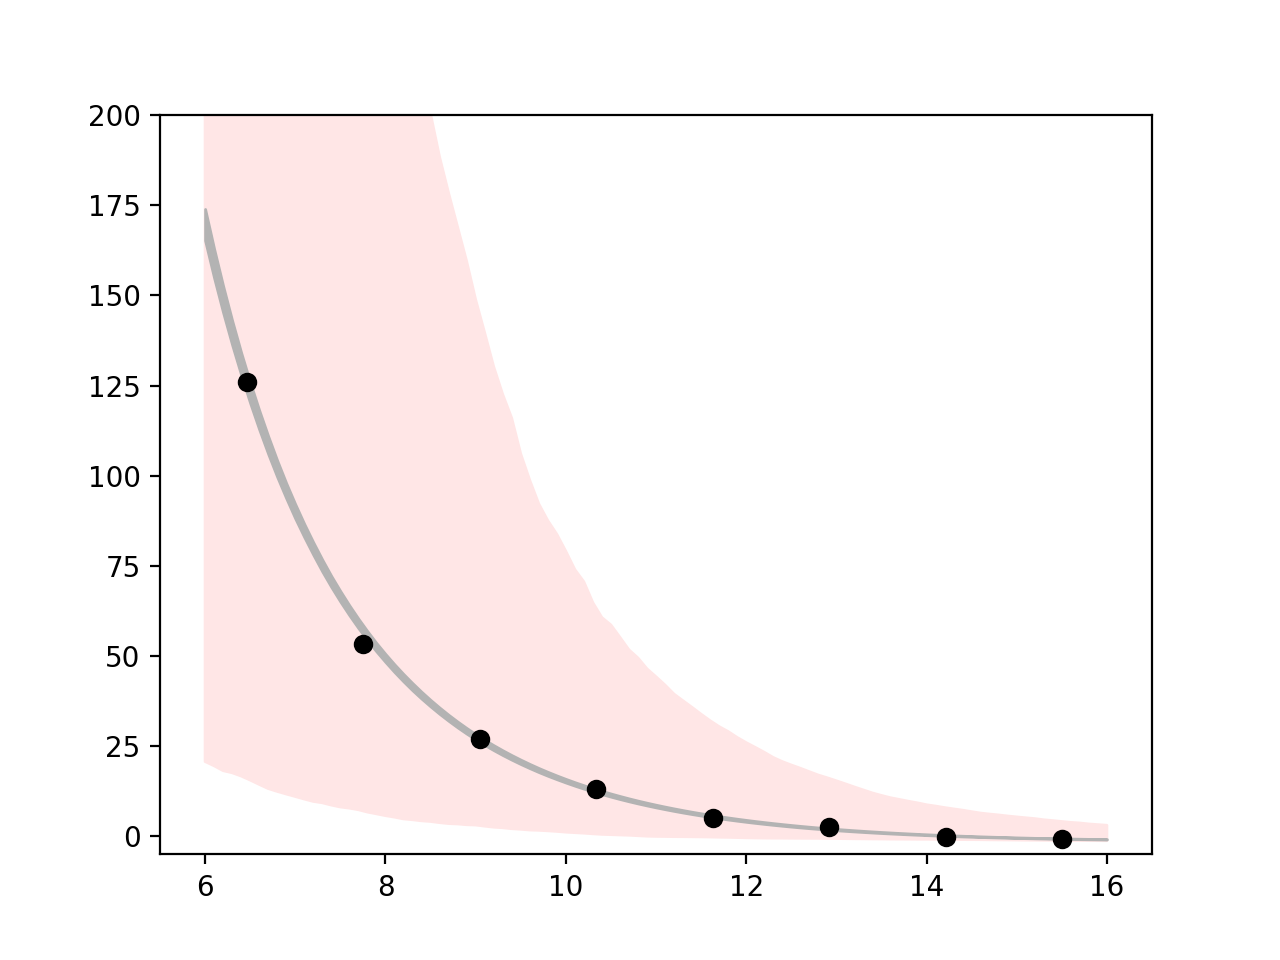

(-5, 200)

In [20]:

plt.figure()
plt.fill_between(Vmod, Pbounds_prior[0], Pbounds_prior[-1], color=[1,.9,.9])
plt.fill_between(Vmod, Pbounds[0], Pbounds[-1], color=[.7,.7,.7])
# plt.plot(Vmod, Pmod_fit, 'r-')
plt.plot(compress_T0_data['table']['V'], compress_T0_data['table']['P'], 'ko')
plt.ylim([-5,200])


In [24]:
RT_eos = copy.deepcopy(analysis['datamodel']['eos_mod'])
RT_eos.apply_electronic = False
RT_eos.heat_capacity(10,3500)/CONSTS['kboltz']
Cv_mod = RT_eos.heat_capacity(tbl['V'], tbl['T'])
Cv_ref_mod = RT_eos.heat_capacity(V_ref, 1773)/CONSTS['kboltz']

In [25]:
datamodel_Cv = datamod.init_datamodel(heat_capacity_data, RT_eos)

fit_calcs = ['bcoef', 'thermal']
fix_params = ['Cvlimfac','mexp', 'V0']
# datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])
eos_fit_params = datamod.select_eos_fit_params(datamodel_Cv, fit_calcs, fix_params=fix_params)
eos_fit_params

['_bcoef_0', '_bcoef_1', '_bcoef_2', '_bcoef_3', '_bcoef_4']

In [26]:
param_init = [1, 1, 1, 1, 1]
# param_init = [1.009, 0.7, -1.4, -15.2, -17.3]

Cv_prior = modfit.ModelPDF(
    ['_bcoef_0', '_bcoef_1', '_bcoef_2', '_bcoef_3', '_bcoef_4'], 
    param_init, [0.3,10,10,10,10])


datamod.set_model_pdf(datamodel_Cv, Cv_prior)

In [27]:
model_pdf_all = datamodel_T0['model_pdf'].expand(
    datamodel_Cv['model_pdf'])
datamod.set_model_pdf(datamodel_Cv, model_pdf_all)

['V0' 'K0' 'KP0' '_bcoef_0' '_bcoef_1' '_bcoef_2' '_bcoef_3' '_bcoef_4']
[[ 1.   -0.16 -0.63  0.    0.    0.    0.    0.  ]
 [-0.16  1.   -0.43  0.    0.    0.    0.    0.  ]
 [-0.63 -0.43  1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.  ]]
[ 0.11  0.29  0.12  0.3  10.   10.   10.   10.  ]


<IPython.core.display.Javascript object>


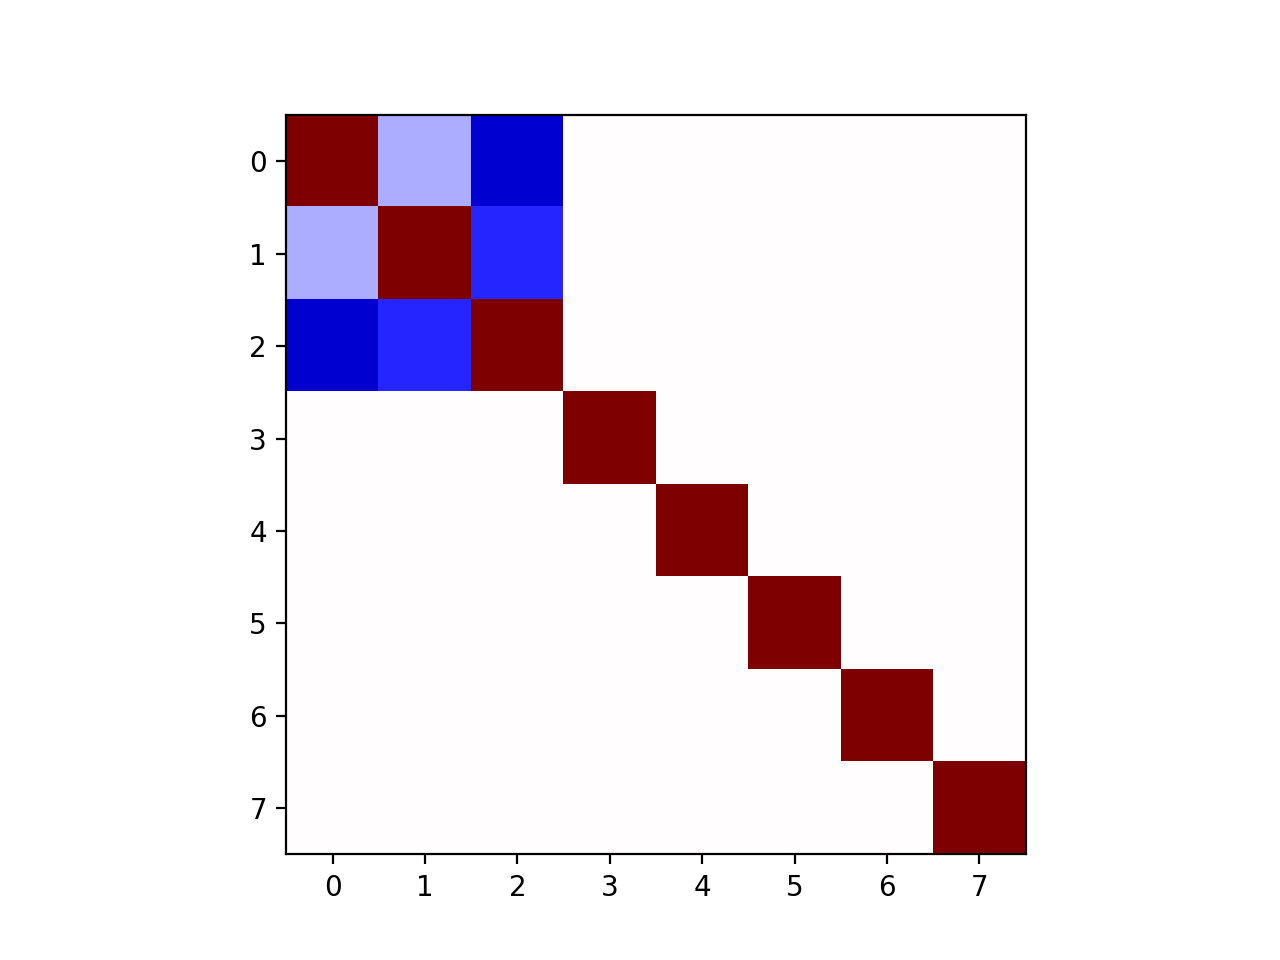

In [28]:
print(model_pdf_all.param_names)
print(np.round(model_pdf_all.param_corr, decimals=2))
print(np.round(model_pdf_all.param_errors, decimals=2))

plt.figure()
plt.imshow(model_pdf_all.param_corr, cmap='seismic')
plt.clim(-1,1)

In [29]:
datamod.fit(datamodel_Cv, apply_bulk_mod_wt=False)
#Cvmod_fit = datamodel_Cv['eos_mod'].heat_capacity(Vmod, T0)
eos_fit = datamodel_Cv['eos_mod']
Cv_fit = eos_fit.heat_capacity(tbl['V'], tbl['T'])
Cv_ref_fit = eos_fit.heat_capacity(V_ref, 1773)/CONSTS['kboltz']

In [30]:
datamodel_Cv['model_pdf'].param_table

,name,value,error
0,V0,14.487906,0.023650
1,K0,11.843563,0.062980
2,KP0,7.134593,0.026910
3,_bcoef_0,1.085308,0.009131
4,_bcoef_1,0.998263,0.136590
5,_bcoef_2,0.908039,0.682951
6,_bcoef_3,-2.466178,1.541413
7,_bcoef_4,-1.016913,1.361367


<IPython.core.display.Javascript object>


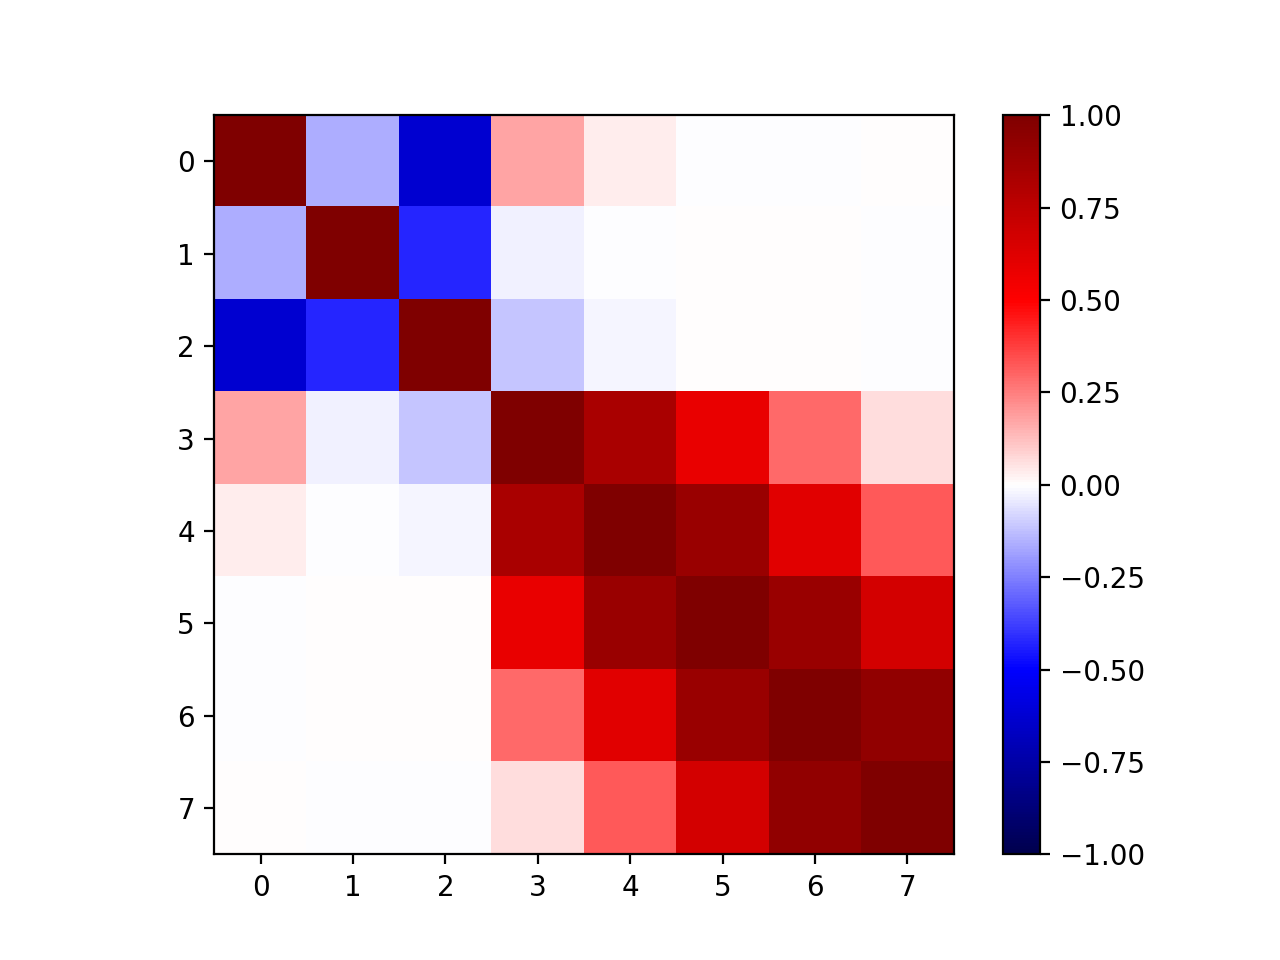

In [31]:
plt.figure()
plt.imshow(datamodel_Cv['model_pdf'].param_corr, cmap='seismic')
plt.clim(-1,1)
plt.colorbar()

In [32]:
Vuniq = np.unique(tbl['V'])
Tmod = np.linspace(1500,5000,101)
Vbnds = [5,15]

def display_Cv_data_fit(Vmodel, Tmodel, Vbounds, tbl,
                        Vthresh=10, dV_sign=+1):
    
    
    if dV_sign>0:
        Vmask = tbl['V']>=Vthresh
        Vmodel_show = Vmodel[Vmodel>=Vthresh]
        if V_ref >= Vthresh:
            show_ref = True
        else:
            show_ref = False
    elif dV_sign<0:
        Vmask = tbl['V']<Vthresh
        Vmodel_show = Vmodel[Vmodel<Vthresh]
        if V_ref < Vthresh:
            show_ref = True
        else:
            show_ref = False
    else:
        Vmask = np.tile(True, len(tbl['V']))
        Vmodel_show = Vmodel
        show_ref = True
        
        
    cmap = plt.get_cmap('gist_earth')
    #cmap = plt.get_cmap('magma')
    # cmap = plt.get_cmap('viridis')
    #cmap = plt.get_cmap('magma')
    col_ref = (V_ref-Vbounds[0])/(Vbounds[1]-Vbounds[0])


    plt.figure()
    plt.scatter(tbl['T'][Vmask],tbl['Cv'][Vmask]/CONSTS['kboltz'], 
                c=tbl['V'][Vmask], cmap=cmap, edgecolor='k', s=100)

    plt.clim(Vbnds)
    
    for iV in Vmodel_show:
        icol = (iV-Vbnds[0])/(Vbnds[-1]-Vbnds[0])
        plt.plot(Tmod, eos_fit.heat_capacity(iV, Tmod)/CONSTS['kboltz'],
             '-', color=cmap(icol))
    
    
    if show_ref:
        plt.plot(1773,4.2,'*', color=cmap(col_ref))


    plt.ylabel('Cv/Nk')
    plt.xlabel('Temperature [K]')
    plt.colorbar(label='V')
    return


<IPython.core.display.Javascript object>


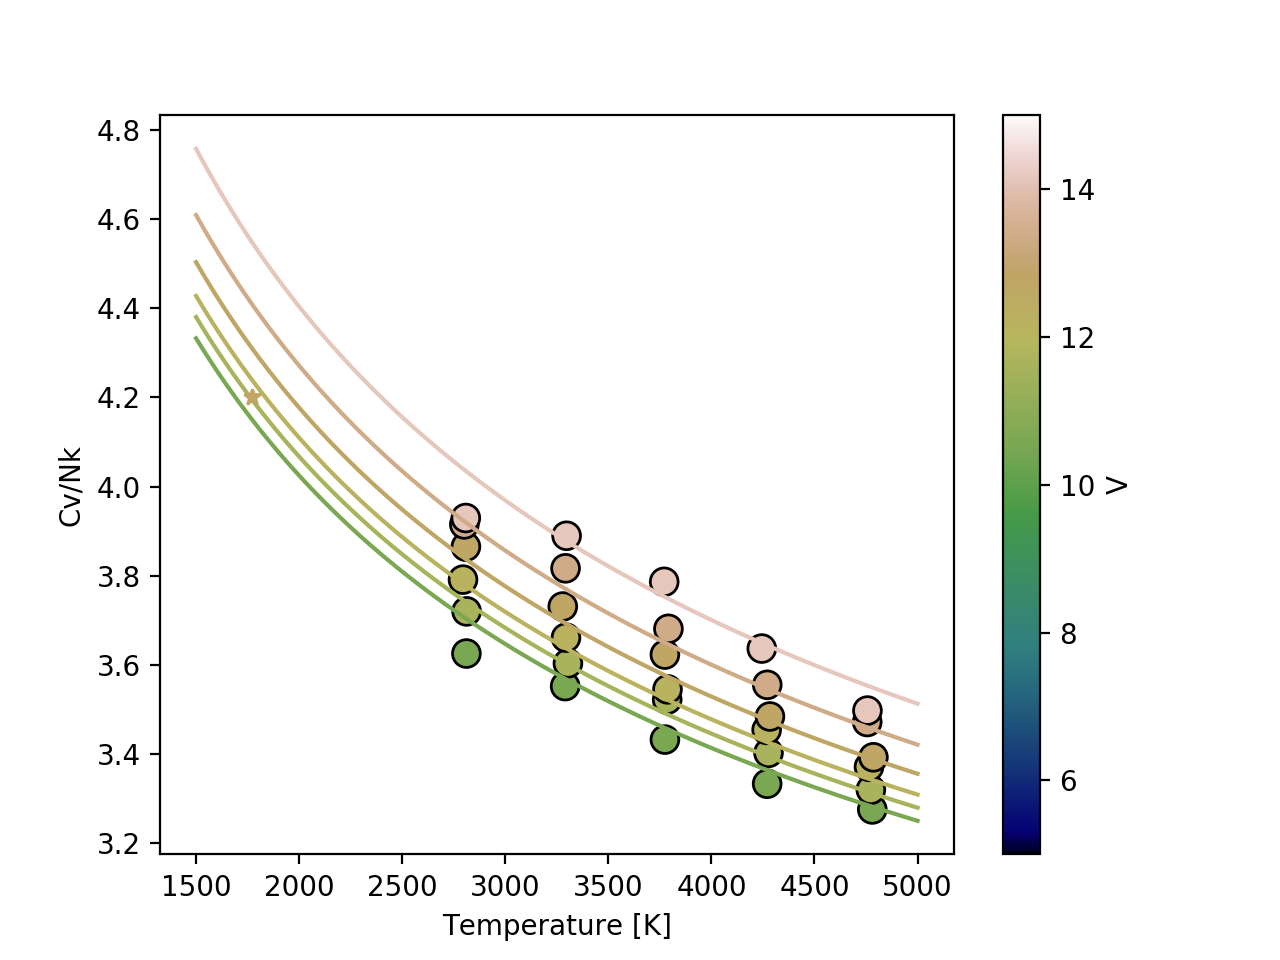

<IPython.core.display.Javascript object>


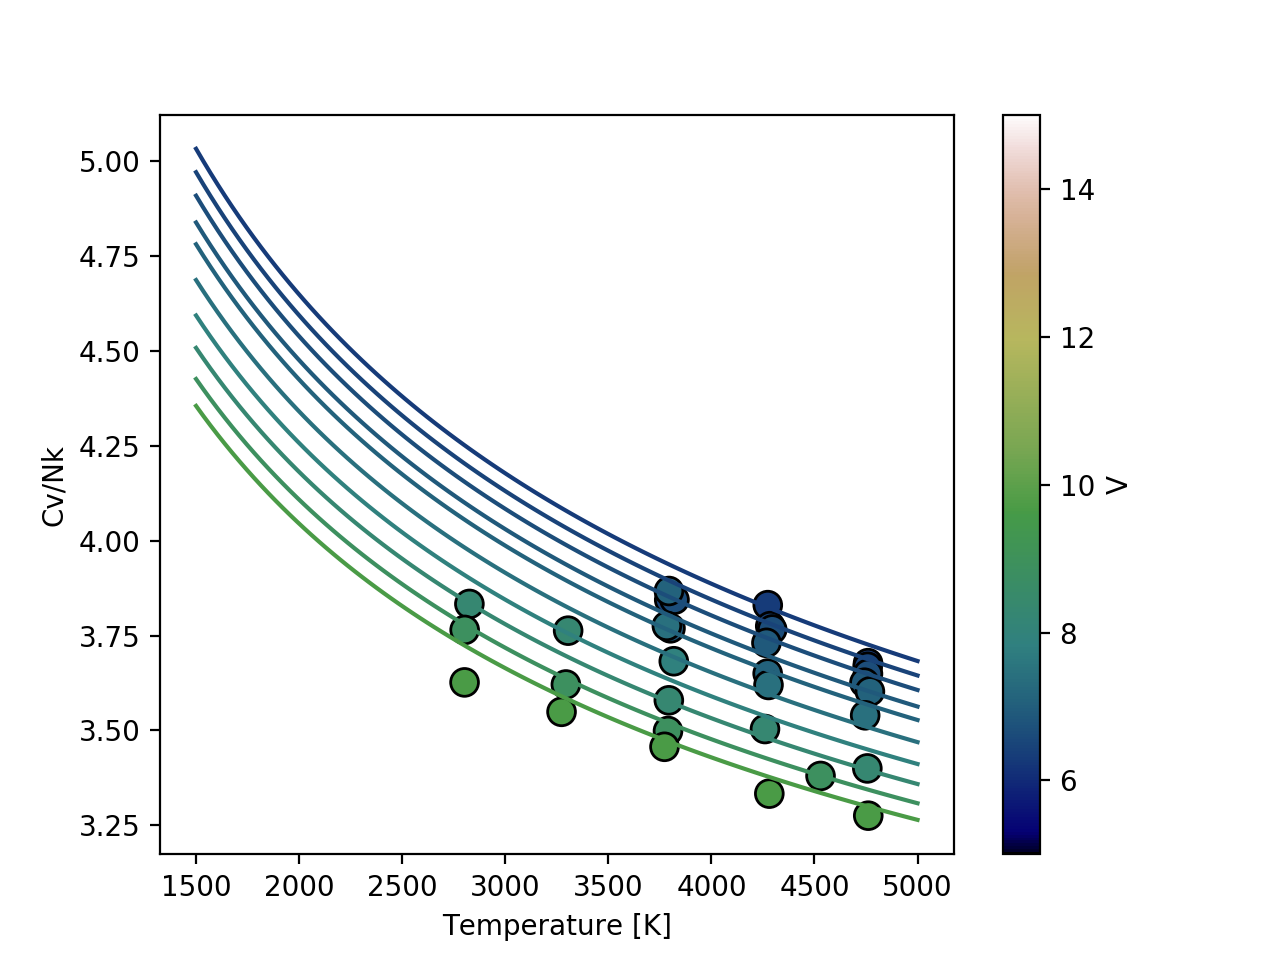

In [33]:
Vmodel = np.unique(tbl['V'])
Tmodel = np.linspace(1500,5000,101)
Vbounds = [5,15]

display_Cv_data_fit(Vmodel, Tmodel, Vbounds, tbl, Vthresh=10, dV_sign=+1)
display_Cv_data_fit(Vmodel, Tmodel, Vbounds, tbl, Vthresh=10, dV_sign=-1)

<IPython.core.display.Javascript object>


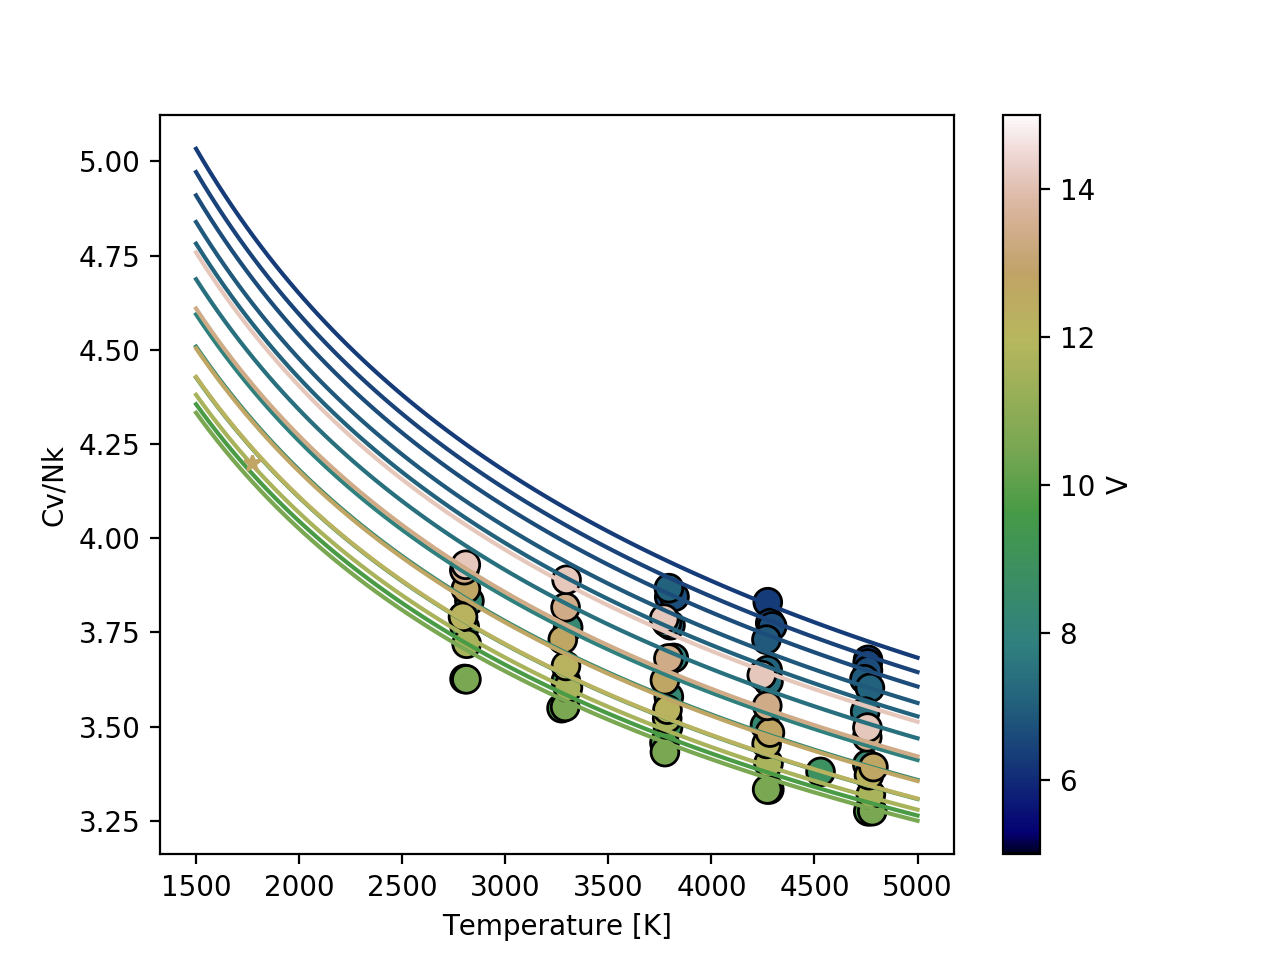

In [34]:
display_Cv_data_fit(Vmodel, Tmodel, Vbounds, tbl, dV_sign=0)

In [35]:
dP_therm_Lange = (props_Lange['T']-T0)*props_Lange['KT']*props_Lange['alpha']


In [46]:
RTpress_eos = copy.deepcopy(analysis['datamodel']['eos_mod'])
RTpress_eos.apply_electronic = False

In [47]:
datamodel_P_thermal = datamod.init_datamodel(thermal_compress_data, RTpress_eos)

fit_calcs = [ 'gamma']
fix_params = ['V0']
# datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])
eos_fit_params = datamod.select_eos_fit_params(datamodel_P_thermal, fit_calcs, fix_params=fix_params)
eos_fit_params

['gamma0', 'gammap0']

In [48]:
RTpress_eos

RTPressEos(kind_compress='Vinet', compress_path_const='T', kind_gamma='GammaFiniteStrain', kind_electronic='CvPowLaw', apply_electronic=False, kind_RTpoly='V', RTpoly_order=4, natom=1, molar_mass=20.080000000000002, model_state={'param_names': ['V0', 'K0', 'KP0', 'gamma0', 'gammap0', 'mexp', 'Cvlimfac', 'CvelFac0', 'CvelFacExp', 'Tel0', 'TelExp', 'S0', 'E0', '_bcoef_0', '_bcoef_1', '_bcoef_2', '_bcoef_3', '_bcoef_4'], 'param_values': [12.949250728485206, 13.20006603991761, 8.238368225973854, 0.18994349597637739, -1.9402423309313312, 0.6, 1.0, 0.0003, 0.6, 3000.0, -0.3, 0.0, -20.595341083955592, 0.982133189959226, 0.6149895513624145, 1.3104950837064218, -3.040061729924666, -4.102279052001586]}, )

In [49]:
param_init = [1, -1]
# param_init = [1.009, 0.7, -1.4, -15.2, -17.3]

gamma_prior = modfit.ModelPDF(
    ['gamma0', 'gammap0'], param_init, [2,2])


datamod.set_model_pdf(datamodel_P_thermal, gamma_prior)

In [50]:
model_pdf_all = datamodel_Cv['model_pdf'].expand(
    datamodel_P_thermal['model_pdf'])
datamod.set_model_pdf(datamodel_P_thermal, model_pdf_all)

['V0' 'K0' 'KP0' '_bcoef_0' '_bcoef_1' '_bcoef_2' '_bcoef_3' '_bcoef_4'
 'gamma0' 'gammap0']
[[ 1.   -0.16 -0.63  0.18  0.04 -0.01 -0.    0.    0.    0.  ]
 [-0.16  1.   -0.43 -0.03 -0.01  0.    0.   -0.    0.    0.  ]
 [-0.63 -0.43  1.   -0.11 -0.02  0.    0.   -0.    0.    0.  ]
 [ 0.18 -0.03 -0.11  1.    0.83  0.58  0.3   0.07  0.    0.  ]
 [ 0.04 -0.01 -0.02  0.83  1.    0.89  0.62  0.32  0.    0.  ]
 [-0.01  0.    0.    0.58  0.89  1.    0.89  0.67  0.    0.  ]
 [-0.    0.    0.    0.3   0.62  0.89  1.    0.93  0.    0.  ]
 [ 0.   -0.   -0.    0.07  0.32  0.67  0.93  1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]]
[0.02 0.06 0.03 0.01 0.14 0.68 1.54 1.36 2.   2.  ]


<IPython.core.display.Javascript object>


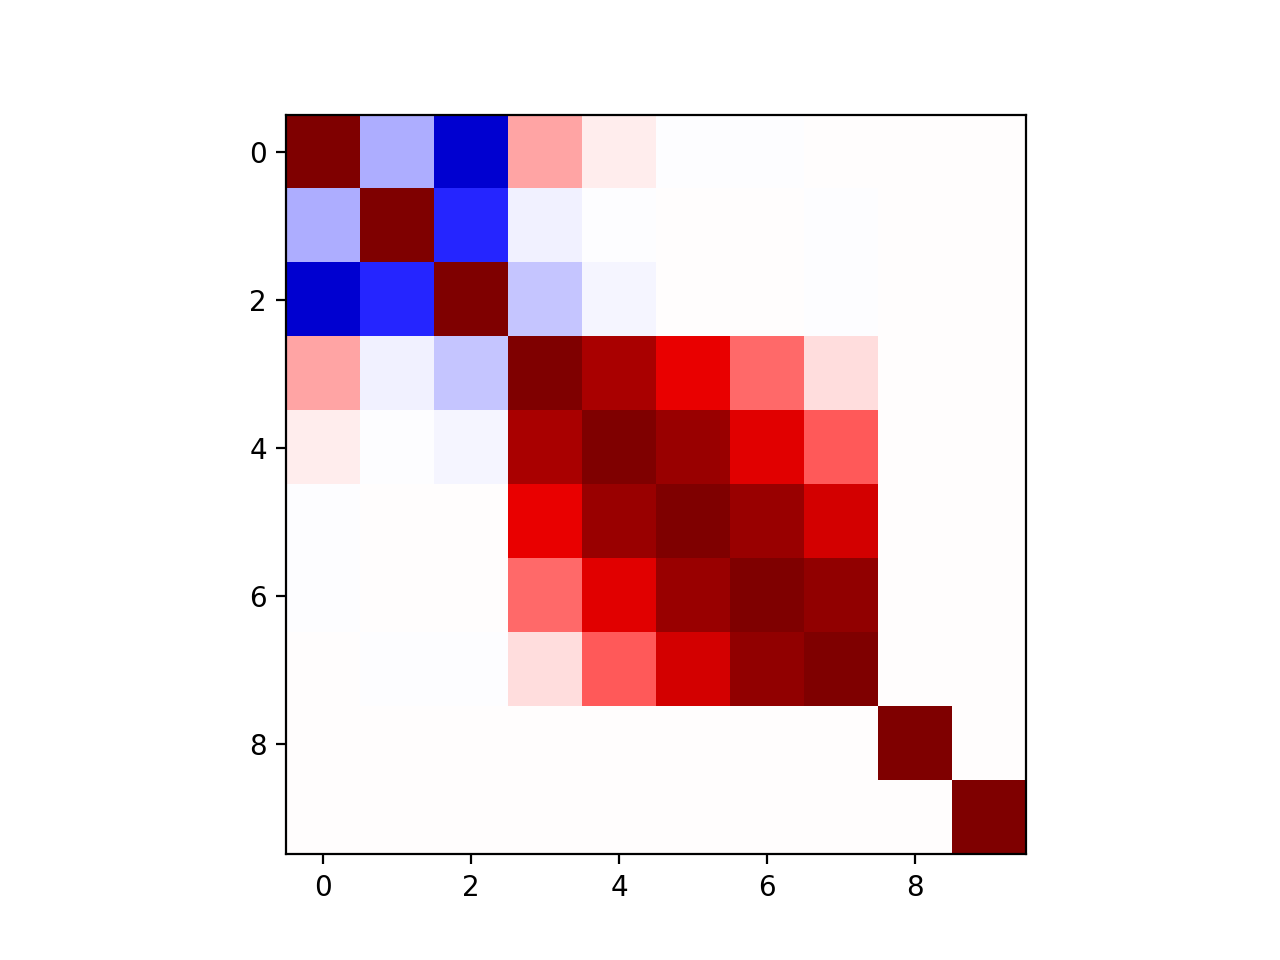

In [51]:
print(model_pdf_all.param_names)
print(np.round(model_pdf_all.param_corr, decimals=2))
print(np.round(model_pdf_all.param_errors, decimals=2))

plt.figure()
plt.imshow(model_pdf_all.param_corr, cmap='seismic')
plt.clim(-1,1)

In [52]:
datamod.fit(datamodel_P_thermal)
eos_fit = datamodel_P_thermal['eos_mod']

T0 = eos_fit.refstate.ref_temp()

P_thermal_fit = eos_fit.press(tbl['V'], tbl['T'])-eos_fit.press(tbl['V'], T0)


<IPython.core.display.Javascript object>


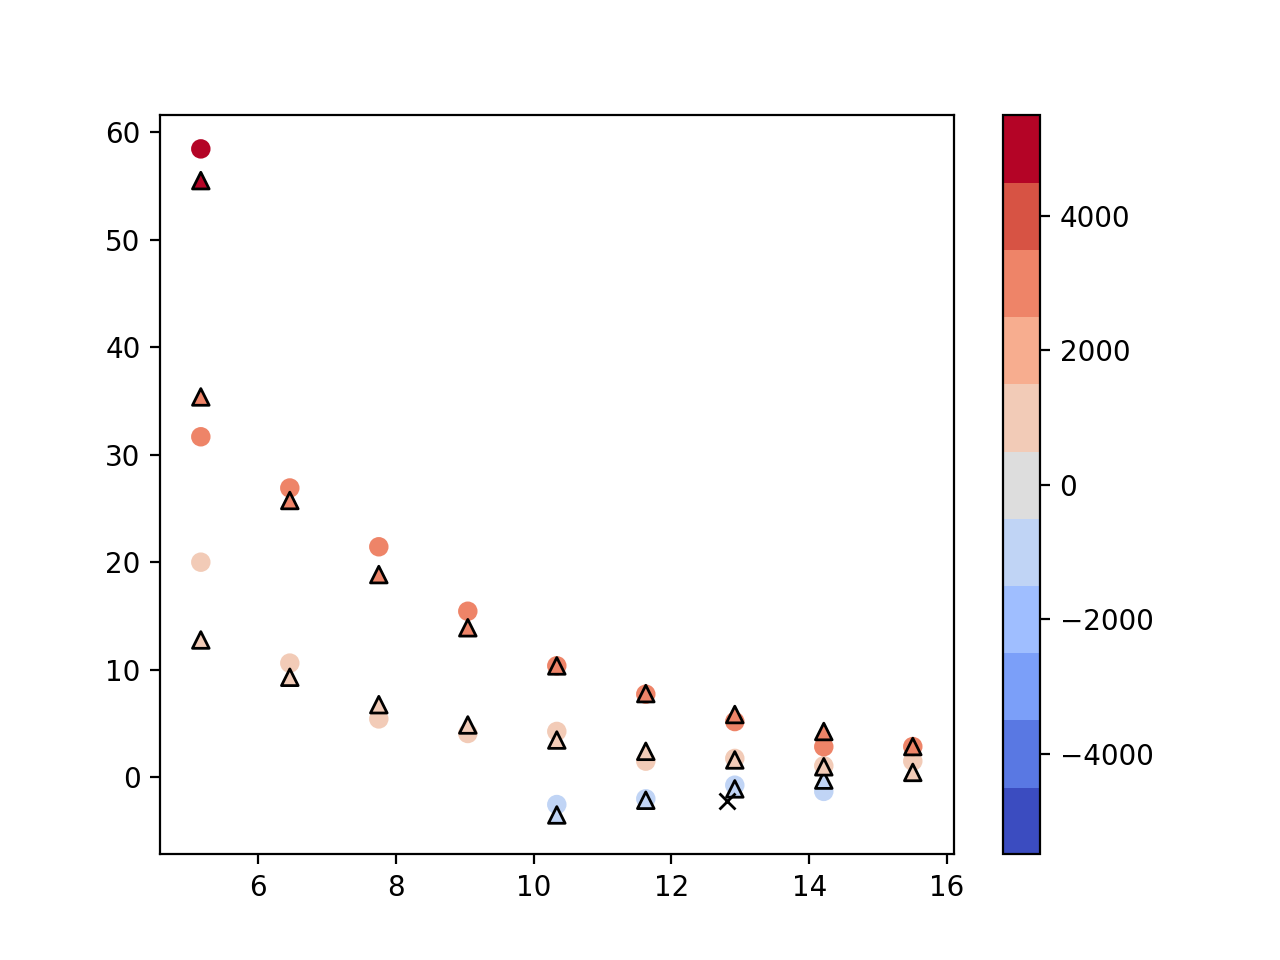

<IPython.core.display.Javascript object>


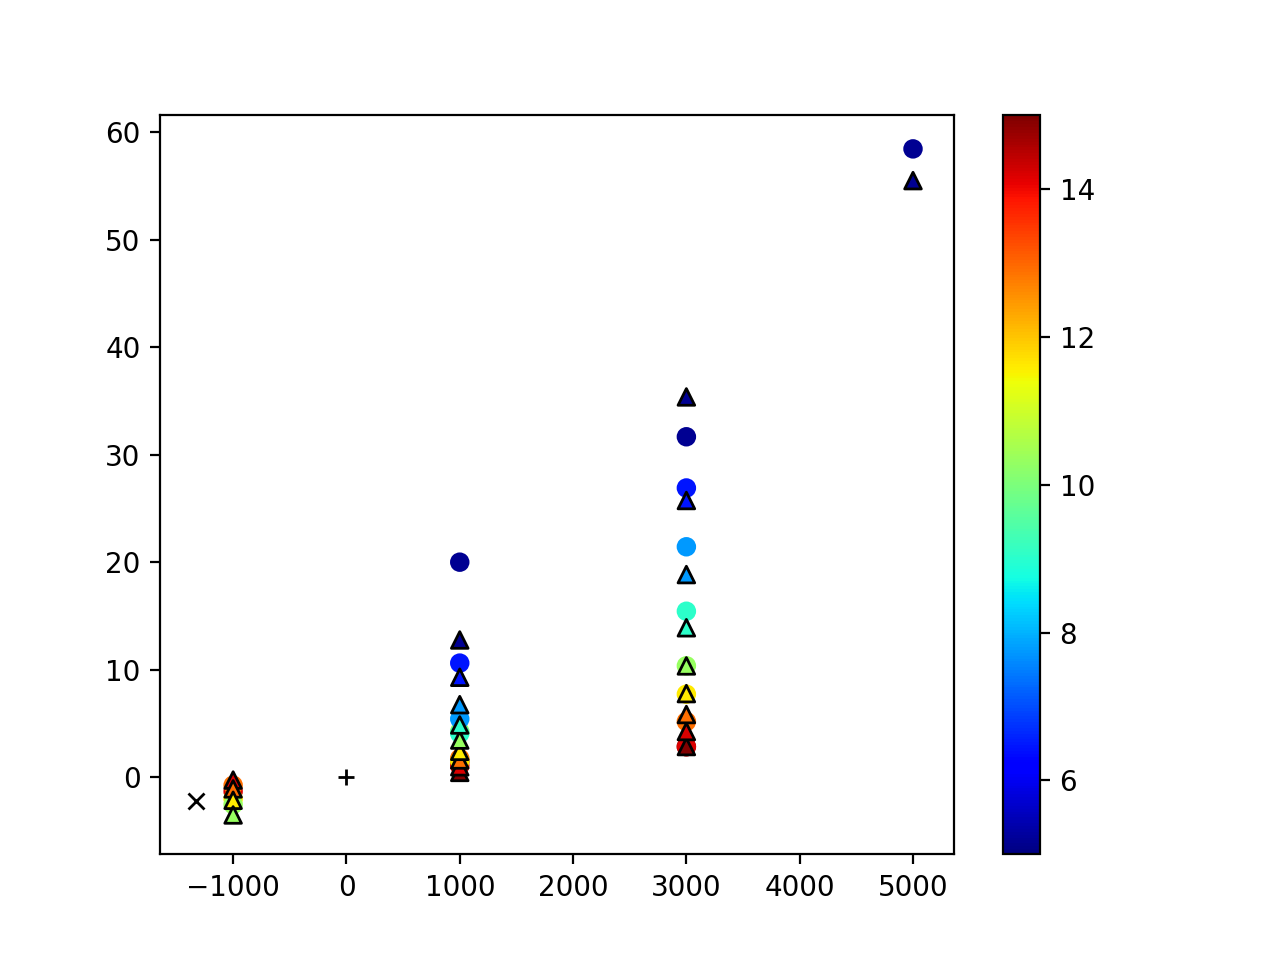

In [57]:
plt.figure()
tbl = thermal_compress_data['table']


plt.scatter(tbl['V'], tbl['P_thermal'], c=tbl['T']-T0, cmap=plt.get_cmap('coolwarm',11))
plt.clim(-5500,5500)
plt.scatter(tbl['V'], P_thermal_fit, c=tbl['T']-T0, marker='^', edgecolor='k',cmap=plt.get_cmap('coolwarm',11))
plt.clim(-5500,5500)
plt.plot(props_Lange['V'], dP_therm_Lange, 'kx')
plt.colorbar()

plt.figure()

plt.scatter(tbl['T']-T0, tbl['P_thermal'], c=tbl['V'],  cmap=plt.get_cmap('jet'))
plt.clim(5,15)
plt.scatter(tbl['T']-T0, P_thermal_fit, c=tbl['V'],  marker='^', edgecolor='k', cmap=plt.get_cmap('jet'))
plt.clim(5,15)
plt.plot( props_Lange['T']-T0, dP_therm_Lange,  'kx')
plt.plot(0,0,'k+')
plt.colorbar()

In [58]:
datamodel_P_thermal['model_pdf'].param_table

,name,value,error
0,V0,14.487910,0.003615
1,K0,11.843562,0.009627
2,KP0,7.134590,0.004113
3,_bcoef_0,1.085252,0.001395
4,_bcoef_1,0.997429,0.020866
5,_bcoef_2,0.907307,0.104315
6,_bcoef_3,-2.456419,0.235289
7,_bcoef_4,-1.000540,0.207634
8,gamma0,0.141844,0.076419
9,gammap0,-1.790011,0.139820


<IPython.core.display.Javascript object>


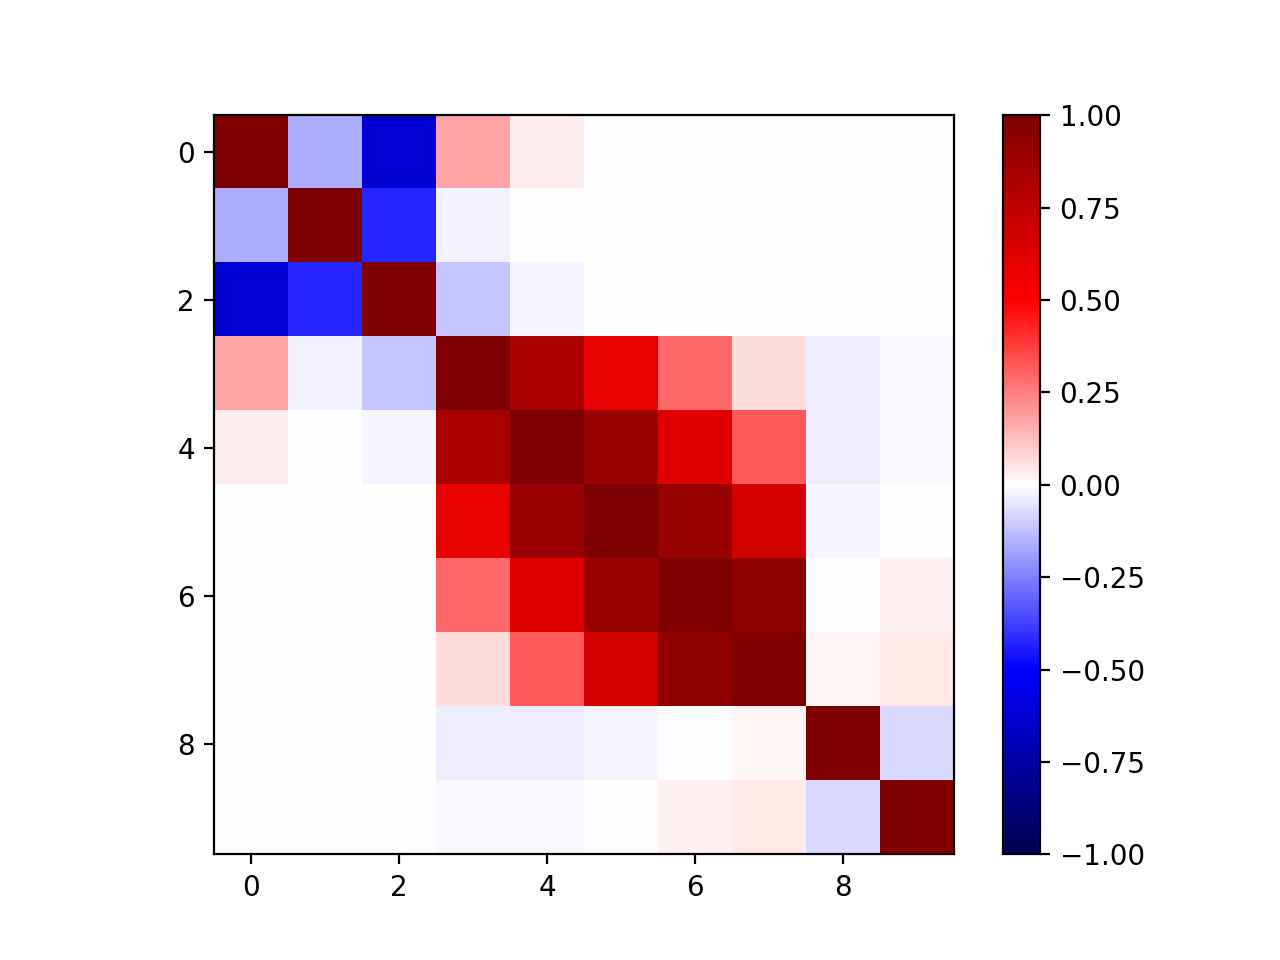

In [61]:
plt.figure()
plt.imshow(datamodel_P_thermal['model_pdf'].param_corr, cmap='seismic')
plt.clim(-1,1)
plt.colorbar()

In [62]:
def load_shock_data(datafile='data/shock-data-Mosenfelder2009.csv'):
    shock_dat = pd.read_csv(datafile,delimiter=',')
    melt_en_mask = ((shock_dat['Starting Material']=='Enstatite')&(shock_dat['Phase State']=='melt'))
    melt_glass_mask = ((shock_dat['Starting Material']=='Glass')&(shock_dat['Phase State']=='melt'))

    melt_enpor_mask = ((shock_dat['Starting Material']=='Porous Enstatite')&(shock_dat['Phase State']=='melt'))
    melt_oxmix_mask = ((shock_dat['Starting Material']=='Oxide mix')&(shock_dat['Phase State']=='melt'))

    shock_dat_melt_glass = shock_dat.loc[melt_glass_mask]
    shock_dat_melt_en = shock_dat.loc[melt_en_mask]
    
    return shock_dat_melt_glass, shock_dat_melt_en

def get_melt_rxn_info():    
    shock_dat_melt_glass, shock_dat_melt_en = load_shock_data()
    
    # Data on pre-melting behavior of enstatite from 
    
    Tmelt = 1816
    

    # Enstatite Hugoniot
    rhoinit_en=np.mean(shock_dat_melt_en['rho0'])
    # rhofaclims_en = [1.59, 1.84]
    rhofaclims_en = np.array([1.6, 1.8])
    # Etrans_en = 2.192455e6*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
    
    #Tmelt_en = 300
    Efus_en = 73.2*1e3/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
    
    # This should probably be integrated from 300K not 273....
    # Eheat_en = 126*(Tmelt-273)/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
    Eheat_en = (126*(Tmelt-273) - 80*(300-273))/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
    Etrans_en = Eheat_en+Efus_en

    melt_rxn_en = {}
    melt_rxn_en['Tmelt'] = Tmelt    
    melt_rxn_en['rhoinit'] = rhoinit_en
    melt_rxn_en['rhofaclims'] = rhofaclims_en
    melt_rxn_en['Etrans'] = Etrans_en

    # Glass Hugoniot
    rhoinit_glass = np.mean(shock_dat_melt_glass['rho0'])
    # rhofaclims_glass = [1.65, 1.94]
    rhofaclims_glass = [1.65, 1.9]
    # Etrans_glass = 1.862455e6*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
    
    # delE_glass = (2.192455e6-1.862455e6)*1e-3/CONSTS['JperHa']*CONSTS['eVperHa']*eos_mod.molar_mass/CONSTS['Nmol']
    # Etrans_glass = Etrans_en - delE_glass
    
    Efus_glass = Efus_en = (73.2-42.1)*1e3/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
    Etrans_glass = Eheat_en + Efus_glass
    
    melt_rxn_glass = {}
    melt_rxn_glass['Tmelt'] = Tmelt    
    melt_rxn_glass['rhoinit'] = rhoinit_glass
    melt_rxn_glass['rhofaclims'] = rhofaclims_glass
    melt_rxn_glass['Etrans'] = Etrans_glass
    
    return melt_rxn_glass, melt_rxn_en

def calc_hugoniot(eos_mod, melt_rxn, Tinit=300):
    hugoniot = eos_mod.hugoniot(
        melt_rxn['rhofaclims'], melt_rxn['rhoinit'], Tinit, 
        Etrans=melt_rxn['Etrans'], Ttrans=melt_rxn['Tmelt'],
        isobar_trans=True)
    
    return hugoniot

In [64]:
shock_dat_melt_glass, shock_dat_melt_en = load_shock_data()
melt_rxn_glass, melt_rxn_en = get_melt_rxn_info()

hugoniot_glass = calc_hugoniot(eos_fit, melt_rxn_glass)
hugoniot_en = calc_hugoniot(eos_fit, melt_rxn_en)



In [65]:
def plot_hugoniot(shock_dat_melt_glass, shock_dat_melt_en,
                  hugoniot_glass_S11, hugoniot_en_S11,
                  hugoniot_glass_dK09, hugoniot_en_dK09,
                  Plim=[50,225], col_glass=[0,0,0], col_en=[.5,.5,.5]):
    
    f, ax_a = plt.subplots(2, 1, sharex='col')

    ax_a[0].errorbar(shock_dat_melt_glass['P'], shock_dat_melt_glass['rho'],
                     xerr=shock_dat_melt_glass['P err'],
                     yerr=shock_dat_melt_glass['rho err'],
                     fmt='.',color=col_glass)
    ax_a[0].errorbar(shock_dat_melt_en['P'], shock_dat_melt_en['rho'],
                     xerr=shock_dat_melt_en['P err'],
                     yerr=shock_dat_melt_en['rho err'],
                     fmt='.',color=col_en)

    ax_a[0].plot(hugoniot_glass_S11['P_a'],hugoniot_glass_S11['rho_a'],
                 '-',color=col_glass)
    ax_a[0].plot(hugoniot_en_S11['P_a'],hugoniot_en_S11['rho_a'],
                 '-',color=col_en)

    ax_a[0].plot(hugoniot_glass_dK09['P_a'],hugoniot_glass_dK09['rho_a'],
                 '--',color=col_glass)
    ax_a[0].plot(hugoniot_en_dK09['P_a'],hugoniot_en_dK09['rho_a'],
                 '--',color=col_en)

    ax_a[0].set_xlim(Plim[0],Plim[1])
    ax_a[0].set_ylabel(u'Density [g/cm$^3$]')

    
    
    ax_a[1].plot(hugoniot_glass_S11['P_a'],hugoniot_glass_S11['T_a'],
                 '-',color=col_glass)
    ax_a[1].plot(hugoniot_en_S11['P_a'],hugoniot_en_S11['T_a'],
                 '-',color=col_en)

    ax_a[1].plot(hugoniot_glass_dK09['P_a'],hugoniot_glass_dK09['T_a'],
                 '--',color=col_glass)
    ax_a[1].plot(hugoniot_en_dK09['P_a'],hugoniot_en_dK09['T_a'],
                 '--',color=col_en)

    ax_a[1].errorbar(shock_dat_melt_glass['P'], shock_dat_melt_glass['TH'],
                     xerr=shock_dat_melt_glass['P err'],
                     yerr=shock_dat_melt_glass['TH err'],
                     fmt='.',color=col_glass)
    ax_a[1].errorbar(shock_dat_melt_en['P'], shock_dat_melt_en['TH'],
                     xerr=shock_dat_melt_en['P err'],
                     yerr=shock_dat_melt_en['TH err'],
                     fmt='.',color=col_en)
    
    ax_a[1].set_xlim(Plim[0],Plim[1])
    ax_a[1].set_xlabel('Pressure  [GPa]')
    ax_a[1].set_ylabel('Temperature  [K]')
    ax_a[1].set_ylim(2000,8000)

    ax_a[0].text(80,4.78,'glass hugoniot',fontsize=12,color=col_glass,
                 verticalalignment='center',horizontalalignment='center',rotation=20)
    ax_a[0].text(150,5.5,'enstatite hugoniot',fontsize=12,color=col_en,
                 verticalalignment='center',horizontalalignment='center',rotation=15)

    ax_a[0].axvspan(136,Plim[1],color = [.95,.95,.95])
    ax_a[1].axvspan(136,Plim[1],color = [.95,.95,.95])


    ax_a[1].text(90,7000,'Terrestrial Mantle\nRegion',fontsize=14,color='k',
                 verticalalignment='top',horizontalalignment='center',weight='bold')

    plt.draw()
    plt.tight_layout(h_pad=.15)
    pass

<IPython.core.display.Javascript object>


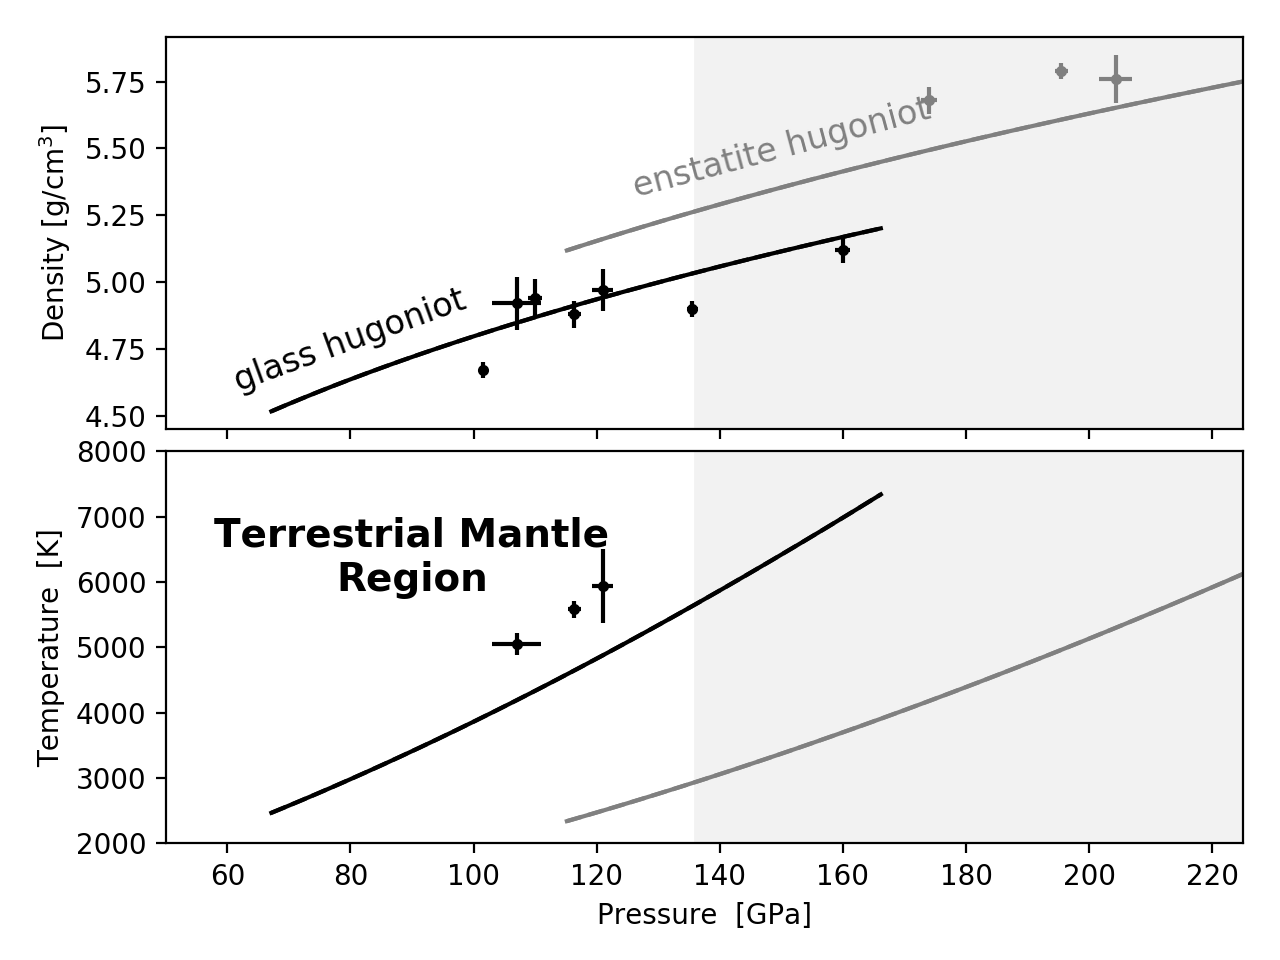

In [67]:
plot_hugoniot(shock_dat_melt_glass, shock_dat_melt_en,
                  hugoniot_glass, hugoniot_en,
                  hugoniot_glass, hugoniot_en)

In [10]:
Vbnds = [5,15]

cmap = plt.get_cmap('gist_earth')
cmap = plt.get_cmap('magma')
# cmap = plt.get_cmap('viridis')
col_ref = (V_ref-Vbnds[0])/(Vbnds[1]-Vbnds[0])

plt.figure()
plt.scatter(thermal_deriv_S11['Tavg'],thermal_deriv_S11['dEdT']/CONSTS['kboltz'], 
            c=thermal_deriv_S11['Vavg'], cmap=cmap, edgecolor='k', s=100)
plt.scatter(thermal_deriv_dK09['Tavg'],thermal_deriv_dK09['dEdT']/CONSTS['kboltz'],
            c=thermal_deriv_dK09['Vavg'], marker='s', cmap=cmap, edgecolor='k', s=100)
plt.plot(1773,4.2,'*', color=cmap(col_ref))
plt.ylabel('Cv/Nk')
plt.colorbar(label='V')

plt.figure()
plt.scatter(thermal_deriv_S11['Tavg'],thermal_deriv_S11['dPdT']*1e3, 
            c=thermal_deriv_S11['Vavg'], cmap=cmap, edgecolor='k', s=100,
            vmin=Vbnds[0],vmax=Vbnds[1])

plt.scatter(thermal_deriv_dK09['Tavg'],thermal_deriv_dK09['dPdT']*1e3, 
            c=thermal_deriv_dK09['Vavg'], marker='s', cmap=cmap, edgecolor='k', s=100,
           vmin=Vbnds[0],vmax=Vbnds[1])


plt.plot(T_ref, dPdT_ref,'*', color=cmap(col_ref))
plt.ylabel('dP/dT  [GPa/1000K]')
plt.colorbar(label='V')

<IPython.core.display.Javascript object>

NameError: name 'thermal_deriv_S11' is not defined

<IPython.core.display.Javascript object>


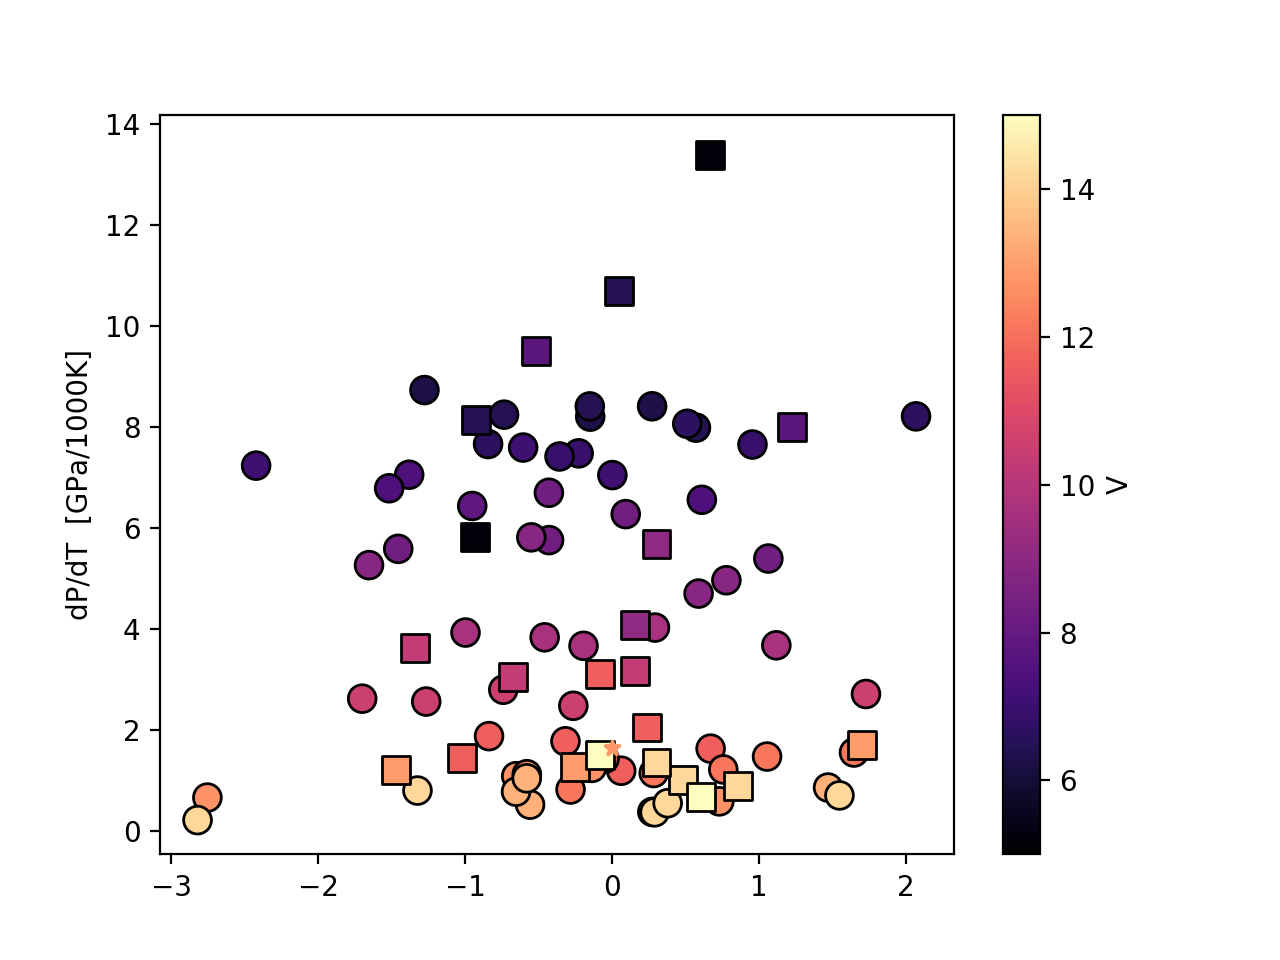

In [31]:
plt.figure()
plt.scatter(np.random.randn(len(thermal_deriv_S11['dPdT'])),thermal_deriv_S11['dPdT']*1e3, 
            c=thermal_deriv_S11['Vavg'], cmap=cmap, edgecolor='k', s=100,
            vmin=Vbnds[0],vmax=Vbnds[1])

plt.scatter(np.random.randn(len(thermal_deriv_dK09['dPdT'])),thermal_deriv_dK09['dPdT']*1e3, 
            c=thermal_deriv_dK09['Vavg'], marker='s', cmap=cmap, edgecolor='k', s=100,
           vmin=Vbnds[0],vmax=Vbnds[1])


plt.plot(dPdT_ref,'*', color=cmap(col_ref))
plt.ylabel('dP/dT  [GPa/1000K]')
plt.colorbar(label='V')

<IPython.core.display.Javascript object>


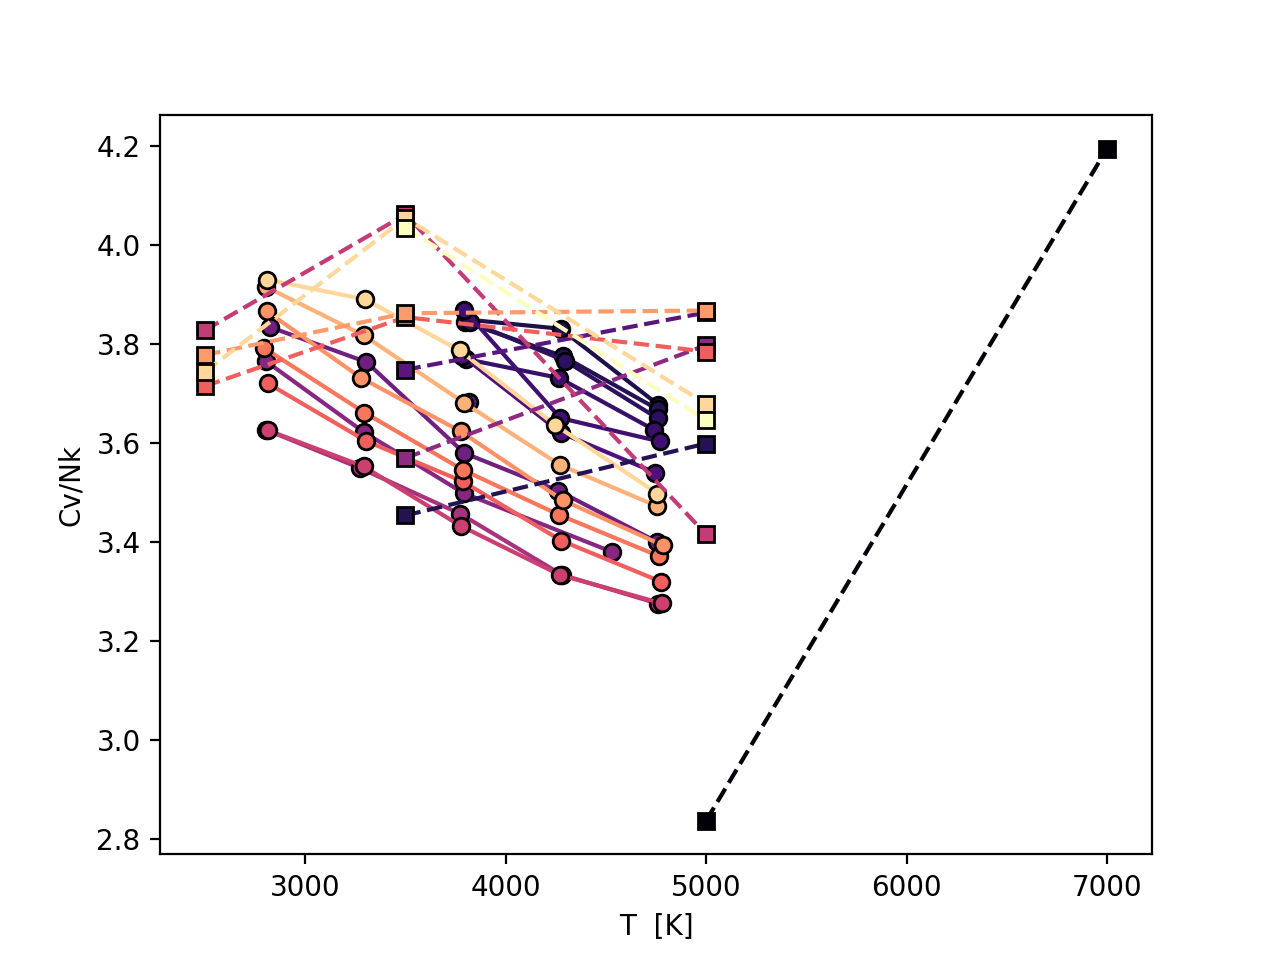

In [151]:

plt.figure()
Vavg = np.unique(thermal_deriv_S11['Vavg'])
for iV in Vavg:
    icol = (iV-Vbnds[0])/(Vbnds[1]-Vbnds[0])
    #icol = (iV-Vavg[0])/(Vavg[-1]-Vavg[0])
    mask = thermal_deriv_S11['Vavg']==iV
    plt.plot(thermal_deriv_S11['Tavg'][mask],thermal_deriv_S11['dEdT'][mask]/CONSTS['kboltz'], 
            'o-', markeredgecolor='k',color = cmap(icol))

Vavg = np.unique(thermal_deriv_dK09['Vavg'])
for iV in Vavg:
    icol = (iV-Vbnds[0])/(Vbnds[1]-Vbnds[0])
    #icol = (iV-Vavg[0])/(Vavg[-1]-Vavg[0])
    mask = thermal_deriv_dK09['Vavg']==iV
    plt.plot(thermal_deriv_dK09['Tavg'][mask],thermal_deriv_dK09['dEdT'][mask]/CONSTS['kboltz'], 
            's--', markeredgecolor='k',color = cmap(icol))
    
plt.ylabel('Cv/Nk')
plt.xlabel('T  [K]')
#plt.colorbar(label='V')

<IPython.core.display.Javascript object>


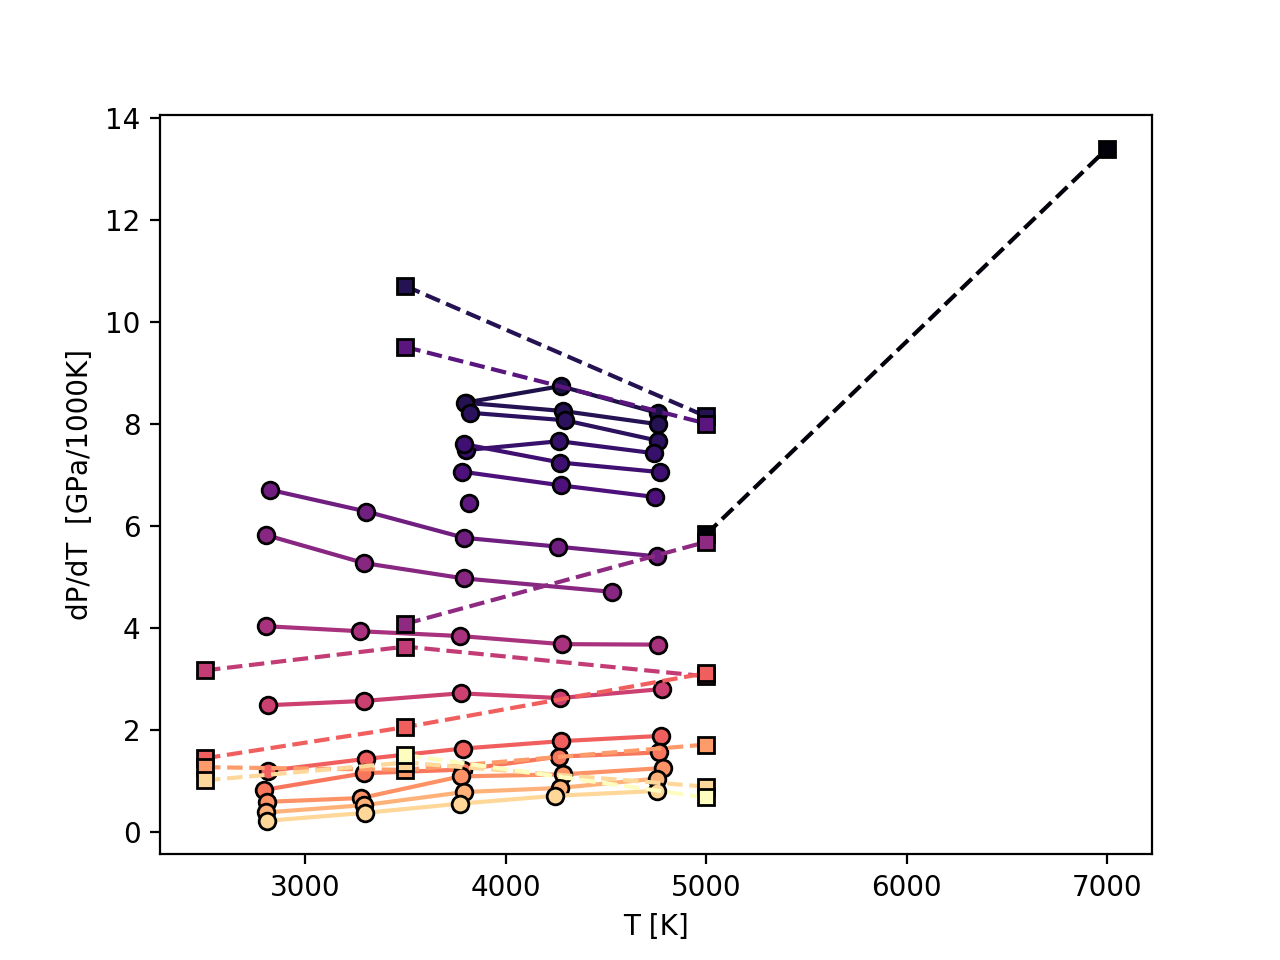

In [152]:
plt.figure()
Vavg = np.unique(thermal_deriv_S11['Vavg'])
for iV in Vavg:
    # icol = (iV-Vavg[0])/(Vavg[-1]-Vavg[0])
    icol = (iV-Vbnds[0])/(Vbnds[1]-Vbnds[0])
    mask = thermal_deriv_S11['Vavg']==iV
    plt.plot(thermal_deriv_S11['Tavg'][mask],thermal_deriv_S11['dPdT'][mask]*1e3, 
            'o-', markeredgecolor='k',color = cmap(icol))

Vavg = np.unique(thermal_deriv_dK09['Vavg'])
for iV in Vavg:
    icol = (iV-Vbnds[0])/(Vbnds[1]-Vbnds[0])
    #icol = (iV-Vavg[0])/(Vavg[-1]-Vavg[0])
    mask = thermal_deriv_dK09['Vavg']==iV
    plt.plot(thermal_deriv_dK09['Tavg'][mask],thermal_deriv_dK09['dPdT'][mask]*1e3, 
            's--', markeredgecolor='k',color = cmap(icol))
    
plt.ylabel('dP/dT  [GPa/1000K]')
plt.xlabel('T [K]')
#plt.colorbar(label='V')

In [182]:
tbl_dK09 = data_dK09['table']
mask_T3K = tbl_dK09['T']==3000

compress_T0_data = pd.DataFrame()
compress_T0_data['V'] = tbl_dK09.loc[mask_T3K, 'V']
compress_T0_data['P'] = tbl_dK09.loc[mask_T3K, 'P']

compress_T0_data.reset_index(inplace=True, drop=True)

thermal_compress_data = tbl_dK09.loc[~mask_T3K]
thermal_compress_data.reset_index(inplace=True, drop=True)
thermal_compress_data



,V,T,P,E,trust,Verr,T_label,V_label
0,14.210892,2000,-1.058632,-7.228171,True,0,2000.0,14.21
1,12.918993,2000,1.302932,-7.240976,True,0,2000.0,12.92
2,11.627094,2000,3.583062,-7.232767,True,0,2000.0,11.63
3,10.335194,2000,10.097720,-7.256082,True,0,2000.0,10.34
4,15.502791,4000,1.051204,-6.476039,True,0,4000.0,15.50
5,14.210892,4000,1.472626,-6.528378,True,0,4000.0,14.21
6,12.918993,4000,3.931708,-6.559818,True,0,4000.0,12.92
7,11.627094,4000,7.207228,-6.562529,True,0,4000.0,11.63
8,10.335194,4000,16.999778,-6.562849,True,0,4000.0,10.34
9,9.043295,4000,31.110825,-6.542476,True,0,4000.0,9.04
